# Statistical Analysis of ETF Returns

## 📈 Understanding Data Behavior through Statistics

In this notebook, we'll perform comprehensive statistical analysis on our ETF returns to understand:

1. **Stationarity**: Are our time series stable over time?
2. **Normality**: Do returns follow a normal distribution?
3. **Volatility**: How does risk evolve over time?
4. **Risk Metrics**: Quantifying investment risk
5. **Autocorrelation**: Are returns predictable?

---

### Why Statistical Analysis Matters in Finance

- **Stationarity** is crucial for time series modeling
- **Normality** affects risk measurement accuracy
- **Volatility clustering** is common in financial markets
- **Risk metrics** guide investment decisions
- **Autocorrelation** can indicate market inefficiencies

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Statistical libraries
from scipy import stats
from scipy.stats import jarque_bera, shapiro, norm, skew, kurtosis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf

# Plot styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [2]:
# Load data from previous analysis
tickers = ["IVV", "IEF", "GLD"]
path = '../data/sample_data.csv'
data = pd.read_csv(path, index_col=0, parse_dates=True, header=[0, 1])

# Extract closing prices
price = pd.DataFrame({t: data[t]['Close'] for t in tickers})

# Calculate log returns (as in previous notebook)
log_returns = np.log(price / price.shift(1)).dropna()
simple_returns = price.pct_change().dropna()

print(f"Data loaded: {price.shape[0]} trading days")
print(f"Returns calculated from {log_returns.index[0].date()} to {log_returns.index[-1].date()}")
print("\nFirst 5 rows of log returns:")
print(log_returns.head())

Data loaded: 5219 trading days
Returns calculated from 2005-01-04 to 2025-09-30

First 5 rows of log returns:
                 IVV       IEF       GLD
Date                                    
2005-01-04 -0.012110 -0.006246 -0.006530
2005-01-05 -0.006068  0.001654 -0.001639
2005-01-06  0.004050  0.000944 -0.012261
2005-01-07 -0.001853 -0.000826 -0.007382
2005-01-10  0.005048 -0.000118  0.002626


## 📊 1. Descriptive Statistics

Basic statistics give us a first look at return characteristics:

Descriptive Statistics of Daily Log Returns:
      count      mean       std  skewness   kurtosis  annual_mean  annual_std
IVV  5218.0  0.000403  0.011982 -0.465027  12.499103     0.101433    0.190209
IEF  5218.0  0.000129  0.004294  0.110086   2.663229     0.032399    0.068158
GLD  5218.0  0.000405  0.011076 -0.299085   5.840016     0.101987    0.175825


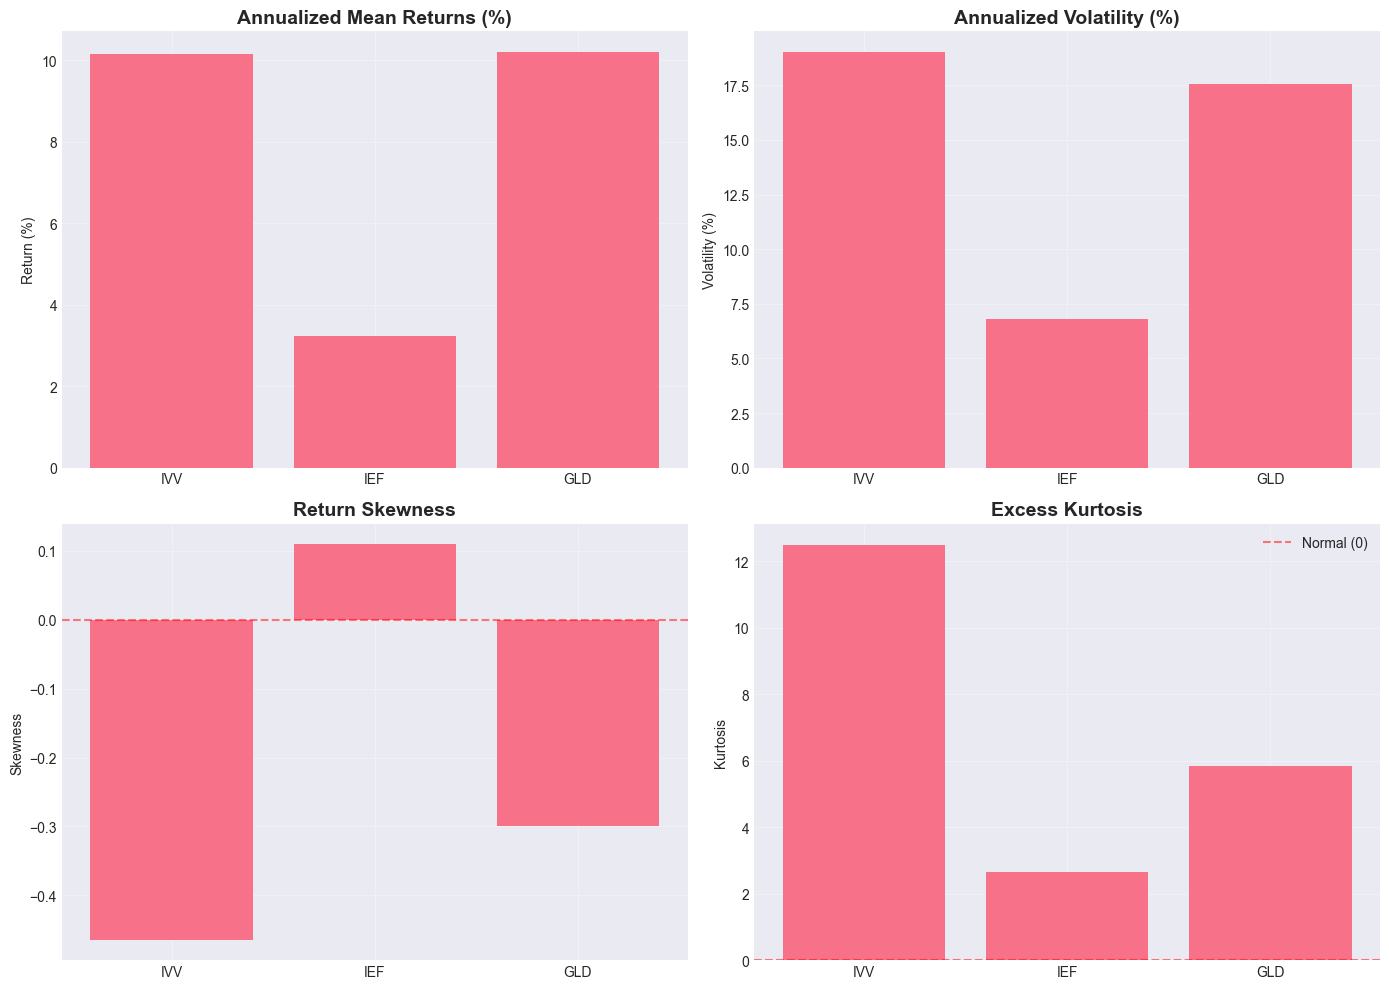

In [3]:
# Descriptive statistics for log returns
desc_stats = log_returns.describe().T
desc_stats['skewness'] = log_returns.skew()
desc_stats['kurtosis'] = log_returns.kurtosis()

# Annualize statistics (assuming 252 trading days)
desc_stats['annual_mean'] = desc_stats['mean'] * 252
desc_stats['annual_std'] = desc_stats['std'] * np.sqrt(252)

print("Descriptive Statistics of Daily Log Returns:")
print("=" * 60)
print(desc_stats[['count', 'mean', 'std', 'skewness', 'kurtosis', 'annual_mean', 'annual_std']])

# Create a summary visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Mean returns comparison
axes[0,0].bar(tickers, desc_stats['annual_mean'] * 100)
axes[0,0].set_title('Annualized Mean Returns (%)', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Return (%)')
axes[0,0].grid(True, alpha=0.3)

# 2. Volatility comparison
axes[0,1].bar(tickers, desc_stats['annual_std'] * 100)
axes[0,1].set_title('Annualized Volatility (%)', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Volatility (%)')
axes[0,1].grid(True, alpha=0.3)

# 3. Skewness
axes[1,0].bar(tickers, desc_stats['skewness'])
axes[1,0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1,0].set_title('Return Skewness', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Skewness')
axes[1,0].grid(True, alpha=0.3)

# 4. Kurtosis (excess kurtosis)
axes[1,1].bar(tickers, desc_stats['kurtosis'])
axes[1,1].axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Normal (0)')
axes[1,1].set_title('Excess Kurtosis', fontsize=14, fontweight='bold')
axes[1,1].set_ylabel('Kurtosis')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Interpretation:

1. **Mean Returns**: Which asset has the highest average return?
2. **Volatility**: Which is the most/least volatile?
3. **Skewness**: Negative skew means more extreme negative returns
4. **Kurtosis**: Positive excess kurtosis indicates "fat tails" - more extreme returns than normal distribution

## 🔄 2. Stationarity Tests

### Why Test for Stationarity?
- **Stationary** series have constant mean, variance, and autocorrelation over time
- Most time series models (ARIMA, GARCH) require stationarity
- Financial returns are typically stationary, but prices are not

We'll use two complementary tests:
1. **ADF Test** (Augmented Dickey-Fuller): Tests for unit root (null hypothesis: non-stationary)
2. **KPSS Test** (Kwiatkowski-Phillips-Schmidt-Shin): Tests for stationarity (null hypothesis: stationary)

In [4]:
def adf_test(series, title=''):
    """Perform Augmented Dickey-Fuller test"""
    result = adfuller(series.dropna())
    print(f'ADF Statistic for {title}: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.6f}')
    
    if result[1] <= 0.05:
        print(f"Result: Stationary (reject H0)")
    else:
        print(f"Result: Non-Stationary (fail to reject H0)")
    print("-" * 60)
    return result[1]

def kpss_test(series, title=''):
    """Perform KPSS test"""
    result = kpss(series.dropna(), regression='c', nlags='auto')
    print(f'KPSS Statistic for {title}: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical Values:')
    for key, value in result[3].items():
        print(f'\t{key}: {value:.6f}')
    
    if result[1] >= 0.05:
        print(f"Result: Stationary (fail to reject H0)")
    else:
        print(f"Result: Non-Stationary (reject H0)")
    print("-" * 60)
    return result[1]

In [5]:
# Test both prices and returns for each ETF
results = []

for ticker in tickers:
    print(f"\n{'='*60}")
    print(f"STATIONARITY TESTS FOR {ticker}")
    print(f"{'='*60}")
    
    # Test prices
    print("\n1. PRICE SERIES:")
    p_adf = adf_test(price[ticker], f'{ticker} Price')
    p_kpss = kpss_test(price[ticker], f'{ticker} Price')
    
    # Test returns
    print("\n2. LOG RETURN SERIES:")
    r_adf = adf_test(log_returns[ticker], f'{ticker} Returns')
    r_kpss = kpss_test(log_returns[ticker], f'{ticker} Returns')
    
    # Store results
    results.append({
        'Ticker': ticker,
        'Price_ADF_p': p_adf,
        'Price_KPSS_p': p_kpss,
        'Return_ADF_p': r_adf,
        'Return_KPSS_p': r_kpss,
        'Price_Stationary': p_adf < 0.05 and p_kpss > 0.05,
        'Return_Stationary': r_adf < 0.05 and r_kpss > 0.05
    })

# Create summary DataFrame
stationarity_summary = pd.DataFrame(results)
print("\n" + "="*60)
print("STATIONARITY SUMMARY")
print("="*60)
print(stationarity_summary.to_string(index=False))


STATIONARITY TESTS FOR IVV

1. PRICE SERIES:
ADF Statistic for IVV Price: 2.851230
p-value: 1.000000
Critical Values:
	1%: -3.431611
	5%: -2.862097
	10%: -2.567067
Result: Non-Stationary (fail to reject H0)
------------------------------------------------------------
KPSS Statistic for IVV Price: 10.324801
p-value: 0.010000
Critical Values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
Result: Non-Stationary (reject H0)
------------------------------------------------------------

2. LOG RETURN SERIES:


C:\Users\vorpc\AppData\Local\Temp\ipykernel_51588\3425867473.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')


ADF Statistic for IVV Returns: -16.204405
p-value: 0.000000
Critical Values:
	1%: -3.431609
	5%: -2.862096
	10%: -2.567066
Result: Stationary (reject H0)
------------------------------------------------------------
KPSS Statistic for IVV Returns: 0.192447
p-value: 0.100000
Critical Values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
Result: Stationary (fail to reject H0)
------------------------------------------------------------

STATIONARITY TESTS FOR IEF

1. PRICE SERIES:


C:\Users\vorpc\AppData\Local\Temp\ipykernel_51588\3425867473.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')


ADF Statistic for IEF Price: -1.553933
p-value: 0.506683
Critical Values:
	1%: -3.431610
	5%: -2.862097
	10%: -2.567066
Result: Non-Stationary (fail to reject H0)
------------------------------------------------------------
KPSS Statistic for IEF Price: 10.166418
p-value: 0.010000
Critical Values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
Result: Non-Stationary (reject H0)
------------------------------------------------------------

2. LOG RETURN SERIES:


C:\Users\vorpc\AppData\Local\Temp\ipykernel_51588\3425867473.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')


ADF Statistic for IEF Returns: -54.204015
p-value: 0.000000
Critical Values:
	1%: -3.431604
	5%: -2.862094
	10%: -2.567065
Result: Stationary (reject H0)
------------------------------------------------------------
KPSS Statistic for IEF Returns: 0.309148
p-value: 0.100000
Critical Values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
Result: Stationary (fail to reject H0)
------------------------------------------------------------

STATIONARITY TESTS FOR GLD

1. PRICE SERIES:


C:\Users\vorpc\AppData\Local\Temp\ipykernel_51588\3425867473.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')


ADF Statistic for GLD Price: 2.475054
p-value: 0.999041
Critical Values:
	1%: -3.431604
	5%: -2.862094
	10%: -2.567065
Result: Non-Stationary (fail to reject H0)
------------------------------------------------------------
KPSS Statistic for GLD Price: 7.633791
p-value: 0.010000
Critical Values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
Result: Non-Stationary (reject H0)
------------------------------------------------------------

2. LOG RETURN SERIES:


C:\Users\vorpc\AppData\Local\Temp\ipykernel_51588\3425867473.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')


ADF Statistic for GLD Returns: -72.939678
p-value: 0.000000
Critical Values:
	1%: -3.431604
	5%: -2.862094
	10%: -2.567065
Result: Stationary (reject H0)
------------------------------------------------------------
KPSS Statistic for GLD Returns: 0.190738
p-value: 0.100000
Critical Values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
Result: Stationary (fail to reject H0)
------------------------------------------------------------

STATIONARITY SUMMARY
Ticker  Price_ADF_p  Price_KPSS_p  Return_ADF_p  Return_KPSS_p  Price_Stationary  Return_Stationary
   IVV     1.000000          0.01  4.046220e-29            0.1             False               True
   IEF     0.506683          0.01  0.000000e+00            0.1             False               True
   GLD     0.999041          0.01  0.000000e+00            0.1             False               True


C:\Users\vorpc\AppData\Local\Temp\ipykernel_51588\3425867473.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')


## 📉 3. Normality Tests

### Financial Returns are Rarely Normal
- Normal distribution assumes symmetry and thin tails
- Financial returns often exhibit:
  - **Skewness**: Asymmetric returns
  - **Excess kurtosis**: Fat tails (more extreme events)
- We'll test with:
  1. **Jarque-Bera Test**: Tests if skewness and kurtosis match normal distribution
  2. **Shapiro-Wilk Test**: General normality test
  3. **QQ Plots**: Visual comparison with normal distribution

In [6]:
def test_normality(series, title):
    """Perform multiple normality tests"""
    # Remove NaN values
    data = series.dropna()
    
    # Jarque-Bera test
    jb_stat, jb_p = jarque_bera(data)
    
    # Shapiro-Wilk test (limited to 5000 observations)
    if len(data) <= 5000:
        shapiro_stat, shapiro_p = shapiro(data)
    else:
        # For large datasets, use random sample
        sample = np.random.choice(data, 5000, replace=False)
        shapiro_stat, shapiro_p = shapiro(sample)
    
    # Anderson-Darling test
    anderson_result = stats.anderson(data, dist='norm')
    
    print(f"\nNormality Tests for {title}:")
    print(f"  Observations: {len(data):,}")
    print(f"  Mean: {data.mean():.6f}, Std: {data.std():.6f}")
    print(f"  Skewness: {data.skew():.4f}, Kurtosis: {data.kurtosis():.4f}")
    print(f"\n  Jarque-Bera Test:")
    print(f"    Statistic: {jb_stat:.4f}, p-value: {jb_p:.6f}")
    print(f"    Result: {'NOT Normal' if jb_p < 0.05 else 'Normal'}")
    
    print(f"\n  Shapiro-Wilk Test:")
    print(f"    Statistic: {shapiro_stat:.4f}, p-value: {shapiro_p:.6f}")
    print(f"    Result: {'NOT Normal' if shapiro_p < 0.05 else 'Normal'}")
    
    print(f"\n  Anderson-Darling Test (Critical Values):")
    for i in range(len(anderson_result.critical_values)):
        sl, cv = anderson_result.significance_level[i], anderson_result.critical_values[i]
        print(f"    {sl}%: {cv:.4f}", end="")
        if anderson_result.statistic < cv:
            print(" (Normal)")
        else:
            print(" (NOT Normal)")
    
    return {
        'JB_stat': jb_stat, 'JB_p': jb_p,
        'Shapiro_stat': shapiro_stat, 'Shapiro_p': shapiro_p,
        'Anderson_stat': anderson_result.statistic,
        'Skewness': data.skew(), 'Kurtosis': data.kurtosis()
    }

# Test normality for each ETF
normality_results = {}

print("="*60)
print("NORMALITY TESTS FOR ETF RETURNS")
print("="*60)

for ticker in tickers:
    normality_results[ticker] = test_normality(log_returns[ticker], ticker)
    print("\n" + "-"*60)

NORMALITY TESTS FOR ETF RETURNS

Normality Tests for IVV:
  Observations: 5,218
  Mean: 0.000403, Std: 0.011982
  Skewness: -0.4650, Kurtosis: 12.4991

  Jarque-Bera Test:
    Statistic: 34083.1494, p-value: 0.000000
    Result: NOT Normal

  Shapiro-Wilk Test:
    Statistic: 0.8743, p-value: 0.000000
    Result: NOT Normal

  Anderson-Darling Test (Critical Values):
    15.0%: 0.5760 (NOT Normal)
    10.0%: 0.6550 (NOT Normal)
    5.0%: 0.7860 (NOT Normal)
    2.5%: 0.9170 (NOT Normal)
    1.0%: 1.0910 (NOT Normal)

------------------------------------------------------------

Normality Tests for IEF:
  Observations: 5,218
  Mean: 0.000129, Std: 0.004294
  Skewness: 0.1101, Kurtosis: 2.6632

  Jarque-Bera Test:
    Statistic: 1548.3409, p-value: 0.000000
    Result: NOT Normal

  Shapiro-Wilk Test:
    Statistic: 0.9808, p-value: 0.000000
    Result: NOT Normal

  Anderson-Darling Test (Critical Values):
    15.0%: 0.5760 (NOT Normal)
    10.0%: 0.6550 (NOT Normal)
    5.0%: 0.7860 (N

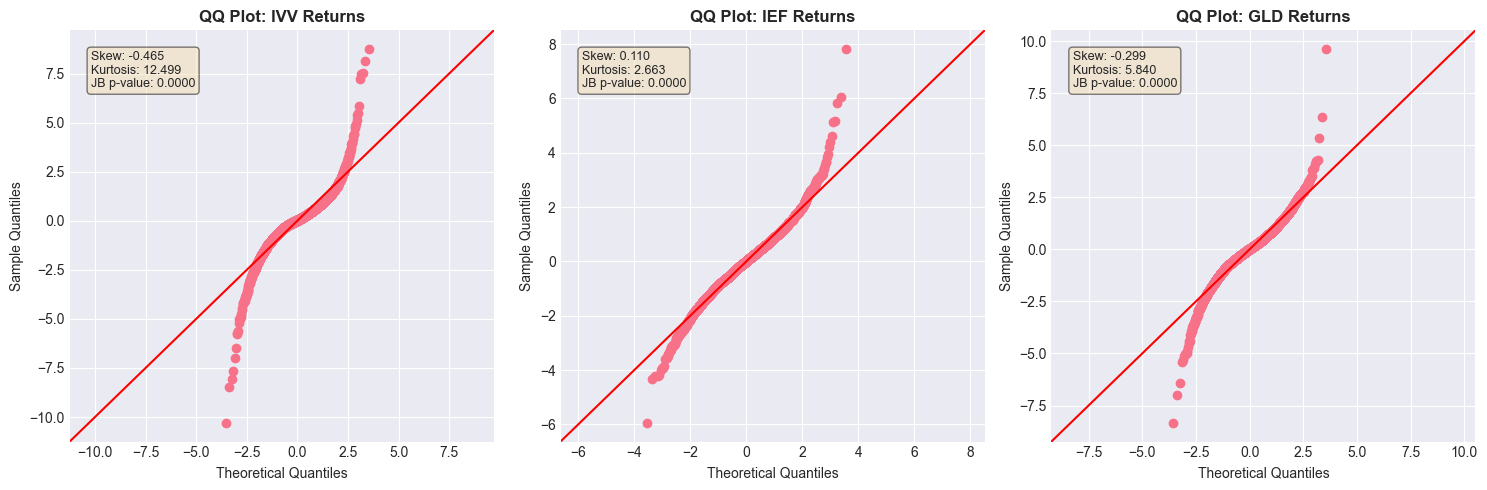

In [7]:
# Create QQ plots for visual normality check
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, ticker in enumerate(tickers):
    # Standardize returns (subtract mean, divide by std)
    returns_standardized = (log_returns[ticker].dropna() - log_returns[ticker].mean()) / log_returns[ticker].std()
    
    # Create QQ plot
    sm.qqplot(returns_standardized, line='45', ax=axes[idx])
    axes[idx].set_title(f'QQ Plot: {ticker} Returns', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Theoretical Quantiles')
    axes[idx].set_ylabel('Sample Quantiles')
    
    # Add statistics to plot
    stats_text = f"Skew: {normality_results[ticker]['Skewness']:.3f}\n"
    stats_text += f"Kurtosis: {normality_results[ticker]['Kurtosis']:.3f}\n"
    stats_text += f"JB p-value: {normality_results[ticker]['JB_p']:.4f}"
    axes[idx].text(0.05, 0.95, stats_text, transform=axes[idx].transAxes, 
                   fontsize=9, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

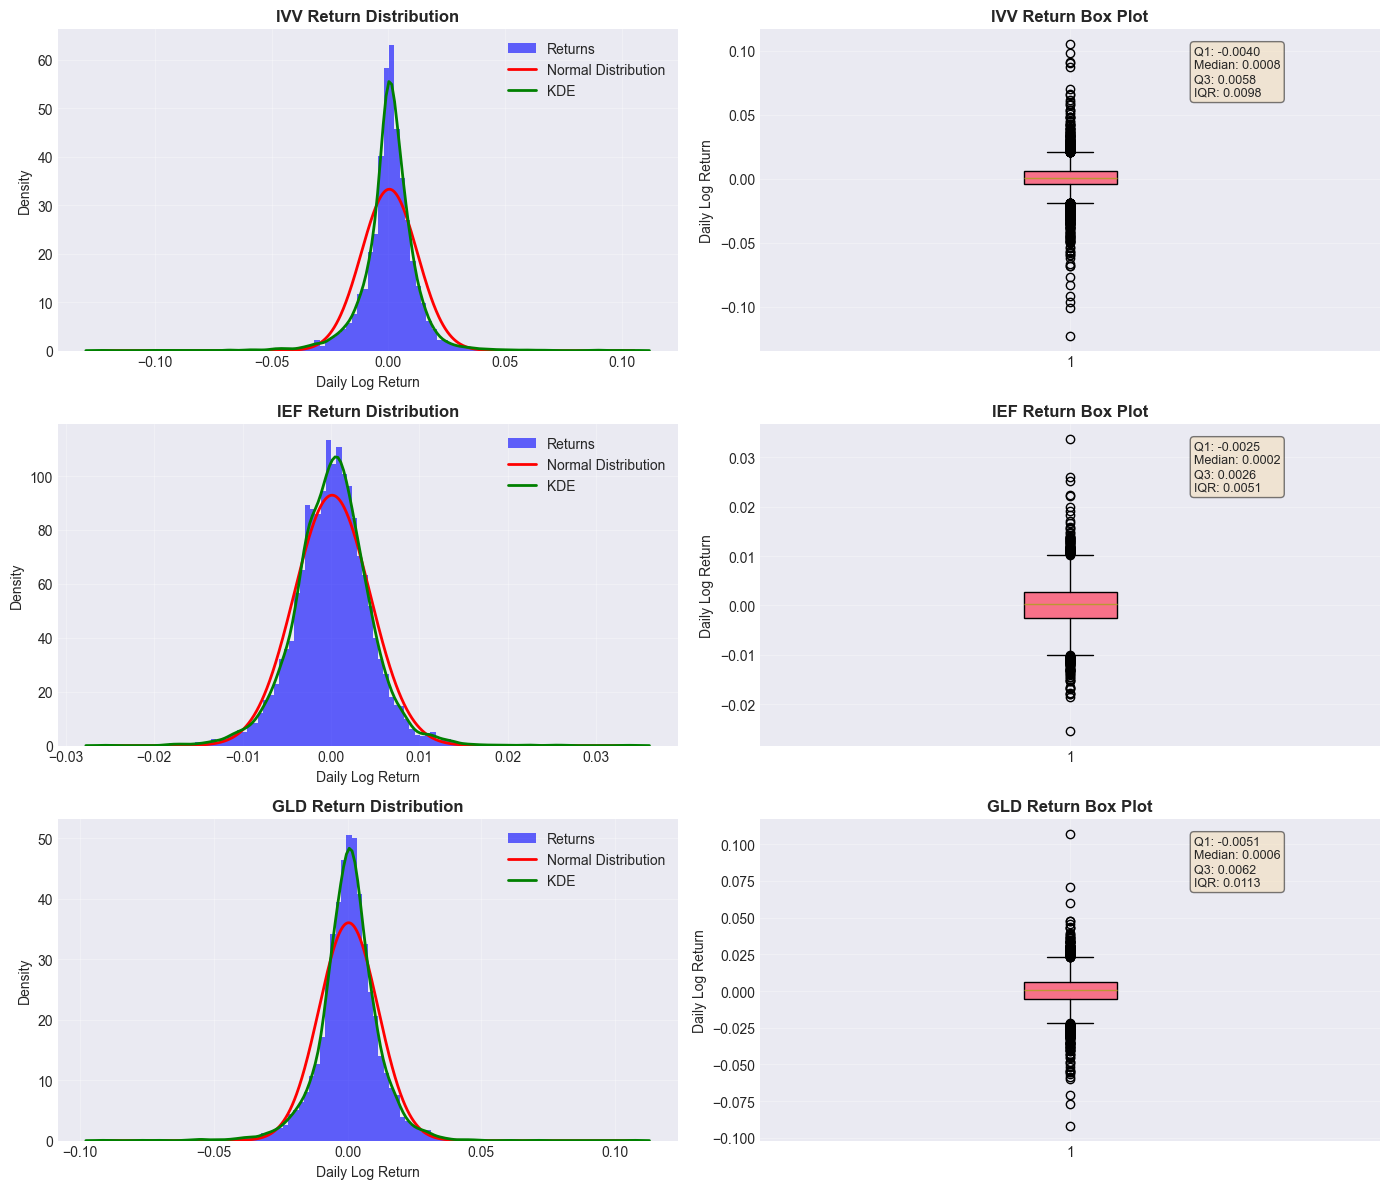

In [8]:
# Visual comparison with normal distribution
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for idx, ticker in enumerate(tickers):
    returns = log_returns[ticker].dropna()
    
    # Histogram with KDE and normal overlay
    axes[idx, 0].hist(returns, bins=100, density=True, alpha=0.6, color='blue', label='Returns')
    
    # Generate normal distribution with same mean and std
    x = np.linspace(returns.min(), returns.max(), 1000)
    normal_pdf = norm.pdf(x, returns.mean(), returns.std())
    axes[idx, 0].plot(x, normal_pdf, 'r-', lw=2, label='Normal Distribution')
    
    # KDE of returns
    sns.kdeplot(returns, ax=axes[idx, 0], color='green', lw=2, label='KDE')
    
    axes[idx, 0].set_title(f'{ticker} Return Distribution', fontsize=12, fontweight='bold')
    axes[idx, 0].set_xlabel('Daily Log Return')
    axes[idx, 0].set_ylabel('Density')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Box plot to show outliers
    axes[idx, 1].boxplot(returns, vert=True, patch_artist=True)
    axes[idx, 1].set_title(f'{ticker} Return Box Plot', fontsize=12, fontweight='bold')
    axes[idx, 1].set_ylabel('Daily Log Return')
    axes[idx, 1].grid(True, alpha=0.3)
    
    # Add statistics to box plot
    stats_text = f"Q1: {returns.quantile(0.25):.4f}\n"
    stats_text += f"Median: {returns.median():.4f}\n"
    stats_text += f"Q3: {returns.quantile(0.75):.4f}\n"
    stats_text += f"IQR: {returns.quantile(0.75) - returns.quantile(0.25):.4f}"
    axes[idx, 1].text(0.7, 0.95, stats_text, transform=axes[idx, 1].transAxes, 
                      fontsize=9, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## 📊 4. Volatility Analysis

### Volatility Clustering in Financial Markets
- High volatility periods tend to cluster together
- Low volatility periods also cluster
- We'll analyze using:
  1. Rolling standard deviation
  2. Exponentially Weighted Moving Average (EWMA)
  3. GARCH model (conditional volatility)

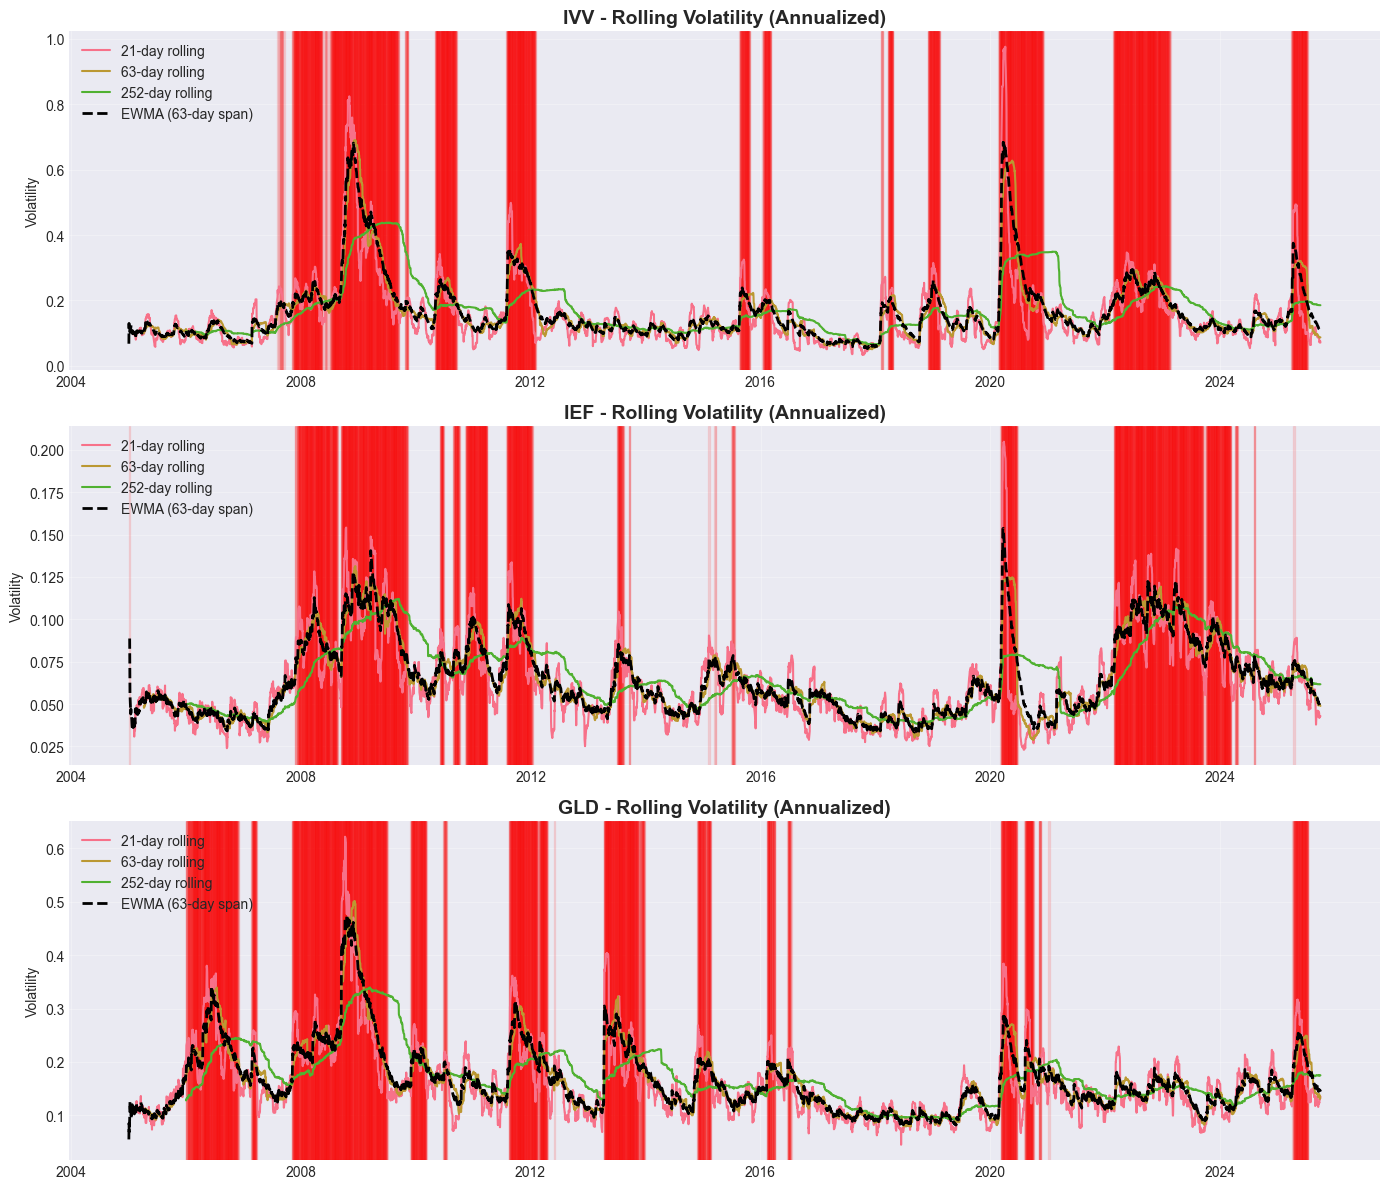

In [9]:
# Calculate rolling volatility (annualized)
rolling_windows = [21, 63, 252]  # 1 month, 3 months, 1 year

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

for idx, ticker in enumerate(tickers):
    ax = axes[idx]
    returns = log_returns[ticker]
    
    # Plot different rolling volatilities
    for window in rolling_windows:
        rolling_vol = returns.rolling(window=window).std() * np.sqrt(252)  # Annualize
        ax.plot(rolling_vol.index, rolling_vol, label=f'{window}-day rolling', linewidth=1.5)
    
    # EWMA volatility (RiskMetrics approach)
    ewma_vol = returns.ewm(span=63).std() * np.sqrt(252)
    ax.plot(ewma_vol.index, ewma_vol, label='EWMA (63-day span)', linewidth=2, linestyle='--', color='black')
    
    ax.set_title(f'{ticker} - Rolling Volatility (Annualized)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Volatility')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # Shade high volatility periods
    high_vol = ewma_vol > ewma_vol.quantile(0.75)
    for date in ewma_vol[high_vol].index:
        ax.axvspan(date - pd.Timedelta(days=5), date + pd.Timedelta(days=5), 
                   alpha=0.1, color='red')

plt.tight_layout()
plt.show()

VOLATILITY STATISTICS (Annualized)
     Realized Vol  Current EWMA Vol  Avg 21-day Vol  Avg 63-day Vol  \
IVV        0.1902            0.1071          0.1573          0.1637   
IEF        0.0682            0.0478          0.0635          0.0646   
GLD        0.1758            0.1448          0.1613          0.1650   

     Avg 252-day Vol  Max 21-day Vol  Min 21-day Vol  \
IVV           0.1740          0.9759          0.0342   
IEF           0.0660          0.2048          0.0230   
GLD           0.1698          0.6219          0.0449   

     Volatility Ratio (Max/Min)  
IVV                     28.5699  
IEF                      8.8891  
GLD                     13.8469  

VOLATILITY CORRELATION
63-day Rolling Volatility Correlation:
        IVV     IEF     GLD
IVV  1.0000  0.6766  0.6282
IEF  0.6766  1.0000  0.4486
GLD  0.6282  0.4486  1.0000


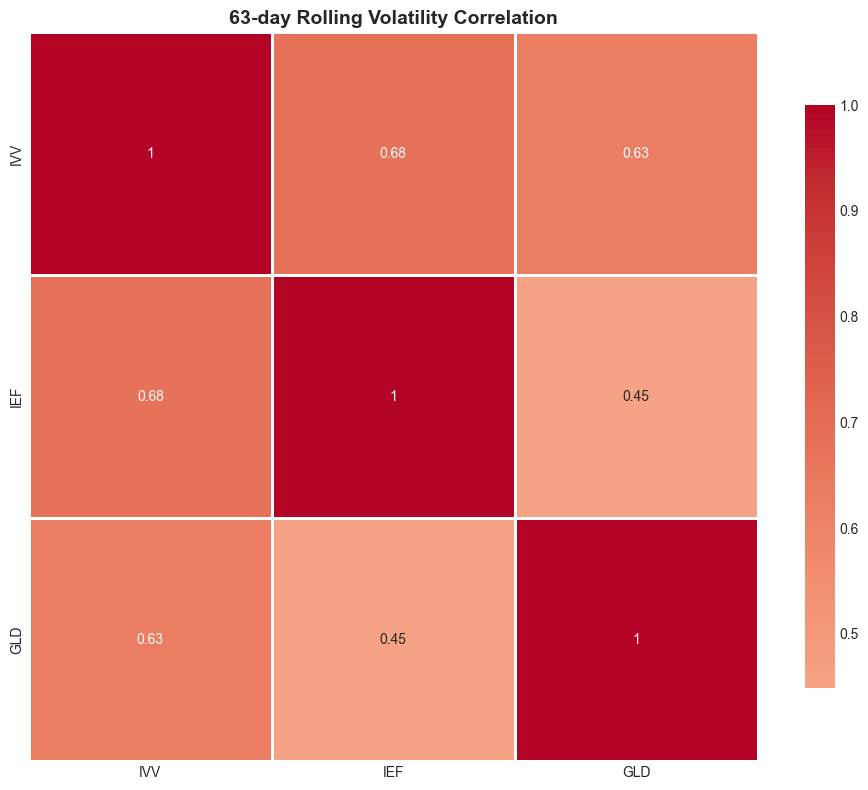

In [10]:
# Volatility statistics
print("VOLATILITY STATISTICS (Annualized)")
print("="*60)

vol_stats = pd.DataFrame()

for ticker in tickers:
    returns = log_returns[ticker]
    
    # Calculate different volatility measures
    realized_vol = returns.std() * np.sqrt(252)
    
    
    ewma_vol = returns.ewm(span=63).std().iloc[-1] * np.sqrt(252)
    
    rolling_21d = returns.rolling(window=21).std().dropna() * np.sqrt(252)
    rolling_63d = returns.rolling(window=63).std().dropna() * np.sqrt(252)
    rolling_252d = returns.rolling(window=252).std().dropna() * np.sqrt(252)
    
    vol_stats[ticker] = {
        'Realized Vol': realized_vol,
        'Current EWMA Vol': ewma_vol,
        'Avg 21-day Vol': rolling_21d.mean(),
        'Avg 63-day Vol': rolling_63d.mean(),
        'Avg 252-day Vol': rolling_252d.mean(),
        'Max 21-day Vol': rolling_21d.max(),
        'Min 21-day Vol': rolling_21d.min(),
        'Volatility Ratio (Max/Min)': rolling_21d.max() / rolling_21d.min() if rolling_21d.min() > 0 else np.nan
    }

print(pd.DataFrame(vol_stats).T.round(4))

# Volatility correlation
print("\nVOLATILITY CORRELATION")
print("="*60)

# Calculate rolling volatility correlation
rolling_corr_matrix = pd.DataFrame()
for ticker in tickers:
    rolling_corr_matrix[ticker] = log_returns[ticker].rolling(window=63).std()
    
rolling_corr_matrix = rolling_corr_matrix.dropna()
corr = rolling_corr_matrix.corr()

print("63-day Rolling Volatility Correlation:")
print(corr.round(4))

# Visualize volatility correlation
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": .8})
plt.title('63-day Rolling Volatility Correlation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 🔄 5. Autocorrelation Analysis

### Do Past Returns Predict Future Returns?
- **Efficient Market Hypothesis** suggests no autocorrelation
- However, volatility often shows autocorrelation (volatility clustering)
- We'll analyze:
  1. Return autocorrelation
  2. Absolute return autocorrelation (volatility clustering)
  3. Squared return autocorrelation

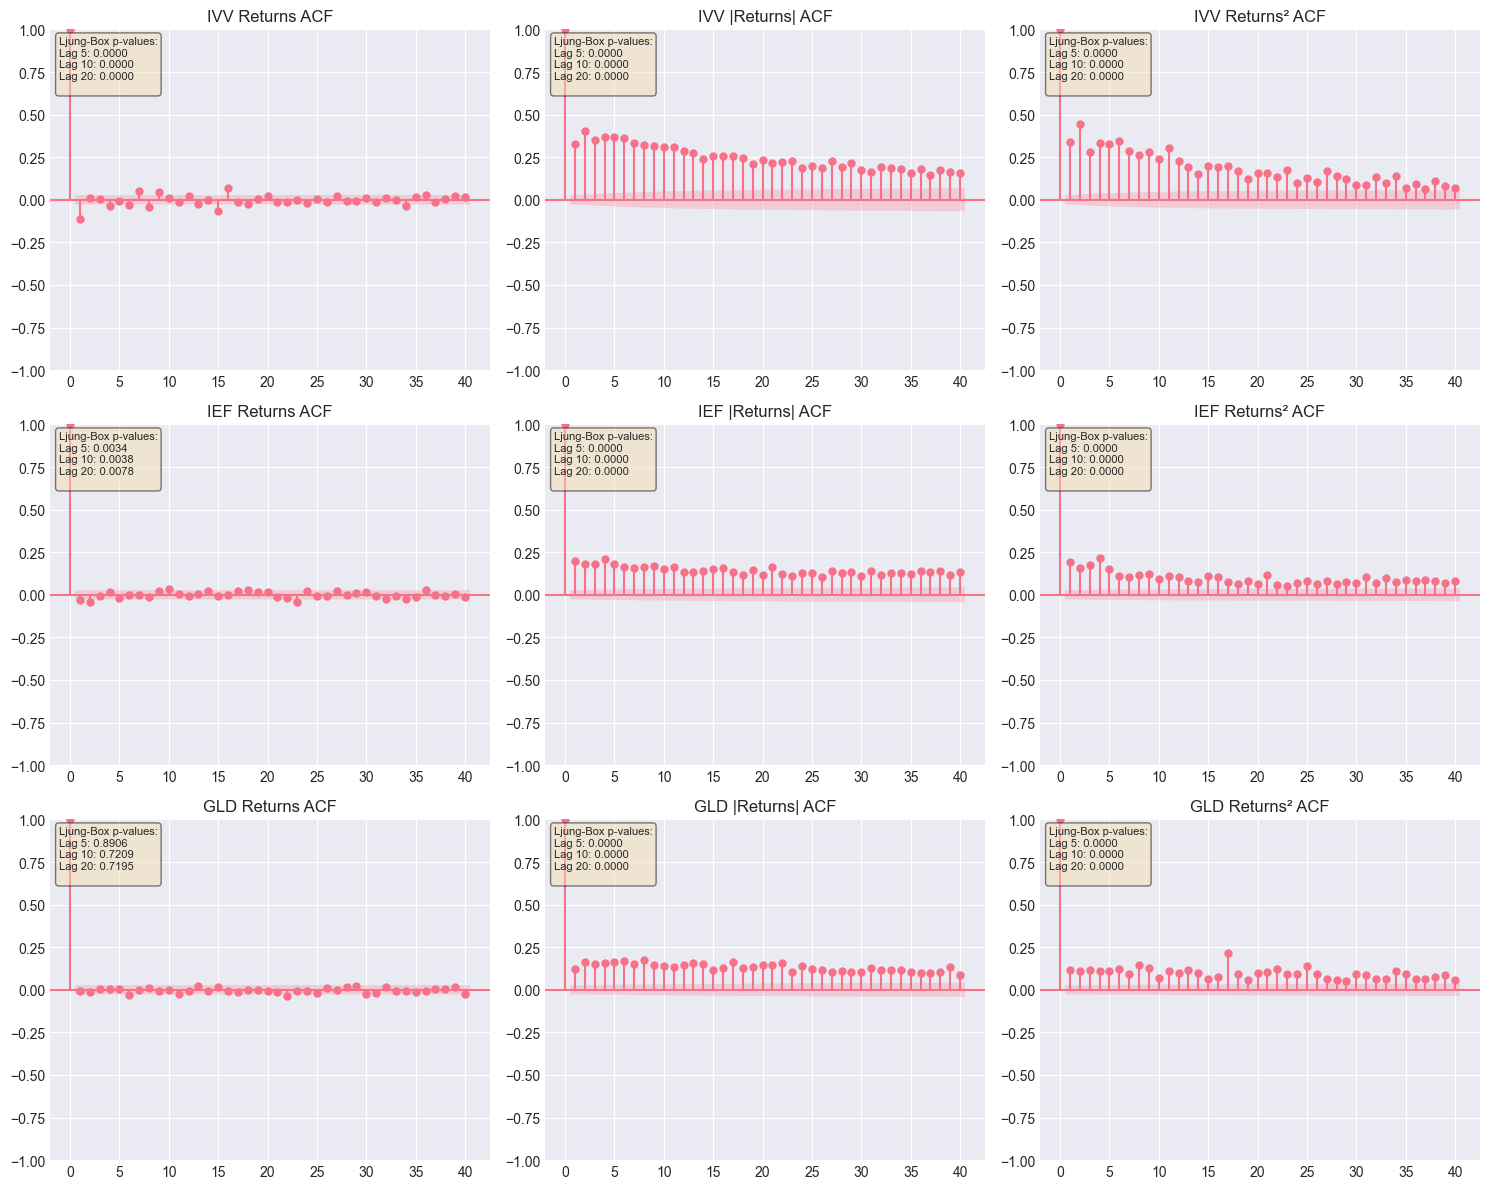

In [11]:
# Create autocorrelation plots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
lags = 40  # Number of lags to show

for idx, ticker in enumerate(tickers):
    returns = log_returns[ticker].dropna()
    
    # 1. Raw returns ACF
    plot_acf(returns, lags=lags, ax=axes[idx, 0], title=f'{ticker} Returns ACF')
    
    # 2. Absolute returns ACF (volatility clustering)
    plot_acf(np.abs(returns), lags=lags, ax=axes[idx, 1], title=f'{ticker} |Returns| ACF')
    
    # 3. Squared returns ACF
    plot_acf(returns**2, lags=lags, ax=axes[idx, 2], title=f'{ticker} Returns² ACF')
    
    # Add Ljung-Box test results
    for j, (data, name) in enumerate([(returns, 'Returns'), 
                                       (np.abs(returns), '|Returns|'), 
                                       (returns**2, 'Returns²')]):
        # Ljung-Box test for autocorrelation
        lb_test = sm.stats.acorr_ljungbox(data, lags=[5, 10, 20], return_df=True)
        
        # Add test results to plot
        text = f"Ljung-Box p-values:\n"
        for lag in [5, 10, 20]:
            pval = lb_test[lb_test['lb_pvalue'].index == lag]['lb_pvalue'].values[0]
            text += f"Lag {lag}: {pval:.4f}\n"
        
        axes[idx, j].text(0.02, 0.98, text, transform=axes[idx, j].transAxes,
                          fontsize=8, verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## ⚠️ 6. Risk Metrics

### Comprehensive Risk Assessment
We'll calculate various risk metrics to understand investment risks:

1. **Sharpe Ratio**: Risk-adjusted return
2. **Sortino Ratio**: Downside risk-adjusted return
3. **Maximum Drawdown**: Worst peak-to-trough decline
4. **Value at Risk (VaR)**: Potential loss at given confidence
5. **Conditional VaR (CVaR)**: Expected loss beyond VaR

RISK METRICS COMPARISON
     Sharpe  Sortino  Max_Drawdown  VaR_95  CVaR_95   Omega  Calmar  \
IVV  0.4281   0.5091       -0.5934 -0.0181  -0.0299  1.1101  0.1709   
IEF  0.1819   0.2785       -0.2471 -0.0068  -0.0094  1.0831  0.1311   
GLD  0.4663   0.6228       -0.4922 -0.0175  -0.0263  1.1085  0.2072   

     Downside_Dev  Upside_Dev  
IVV        0.1600      0.1327  
IEF        0.0445      0.0454  
GLD        0.1316      0.1168  


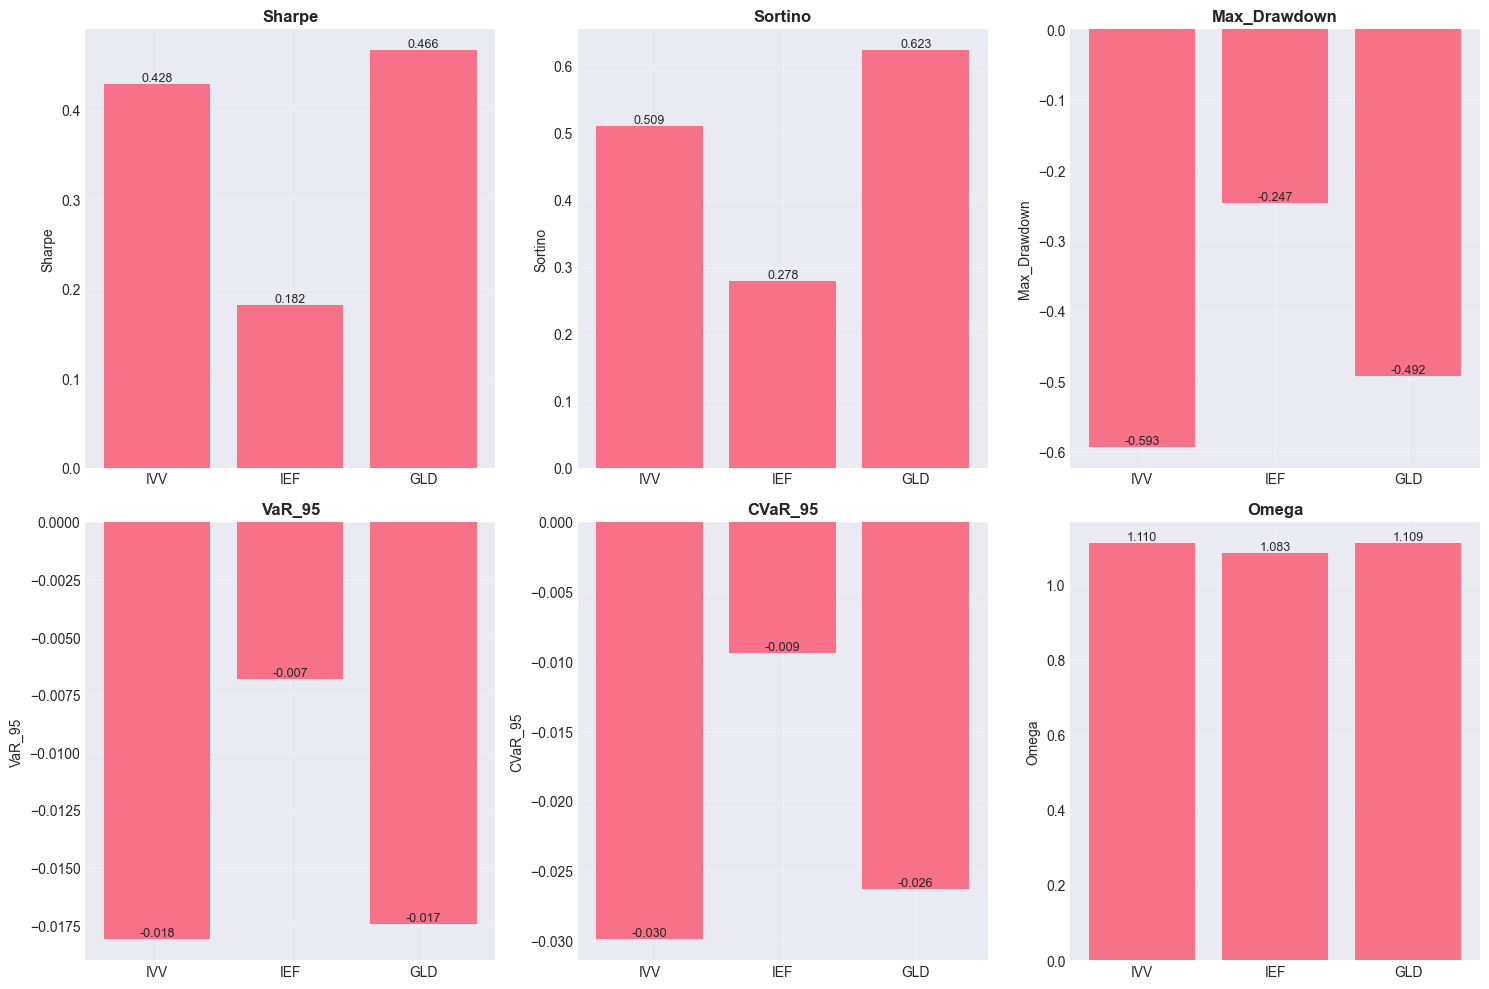

In [12]:
def calculate_risk_metrics(returns, risk_free_rate=0.02, alpha=0.05):
    """Calculate comprehensive risk metrics"""
    # Annualization factor
    days = 252
    
    # Sharpe Ratio
    excess_returns = returns - risk_free_rate/days
    sharpe = np.sqrt(days) * excess_returns.mean() / returns.std()
    
    # Sortino Ratio (only downside deviation)
    downside_returns = returns[returns < 0]
    downside_std = downside_returns.std() if len(downside_returns) > 0 else 0
    sortino = np.sqrt(days) * excess_returns.mean() / downside_std if downside_std > 0 else np.nan
    
    # Maximum Drawdown
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Value at Risk (Historical)
    var_hist = np.percentile(returns, alpha * 100)
    
    # Conditional VaR (Expected Shortfall)
    cvar = returns[returns <= var_hist].mean()
    
    # Omega Ratio
    threshold = risk_free_rate/days
    gains = returns[returns > threshold].sum()
    losses = abs(returns[returns <= threshold].sum())
    omega = gains / losses if losses > 0 else np.nan
    
    # Calmar Ratio
    annual_return = returns.mean() * days
    calmar = annual_return / abs(max_drawdown) if max_drawdown != 0 else np.nan
    
    return {
        'Sharpe': sharpe,
        'Sortino': sortino,
        'Max_Drawdown': max_drawdown,
        'VaR_95': var_hist,
        'CVaR_95': cvar,
        'Omega': omega,
        'Calmar': calmar,
        'Downside_Dev': downside_std * np.sqrt(days),
        'Upside_Dev': returns[returns > 0].std() * np.sqrt(days) if len(returns[returns > 0]) > 0 else 0
    }

# Calculate risk metrics for each ETF
risk_results = {}

print("RISK METRICS COMPARISON")
print("="*60)

for ticker in tickers:
    risk_results[ticker] = calculate_risk_metrics(log_returns[ticker].dropna())
    
# Create DataFrame for display
risk_df = pd.DataFrame(risk_results).T
print(risk_df.round(4))

# Visualize risk metrics
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

metrics_to_plot = ['Sharpe', 'Sortino', 'Max_Drawdown', 'VaR_95', 'CVaR_95', 'Omega']

for idx, metric in enumerate(metrics_to_plot):
    if metric in risk_df.columns:
        bars = axes[idx].bar(tickers, risk_df[metric])
        axes[idx].set_title(metric, fontsize=12, fontweight='bold')
        axes[idx].set_ylabel(metric)
        axes[idx].grid(True, alpha=0.3)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                          f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

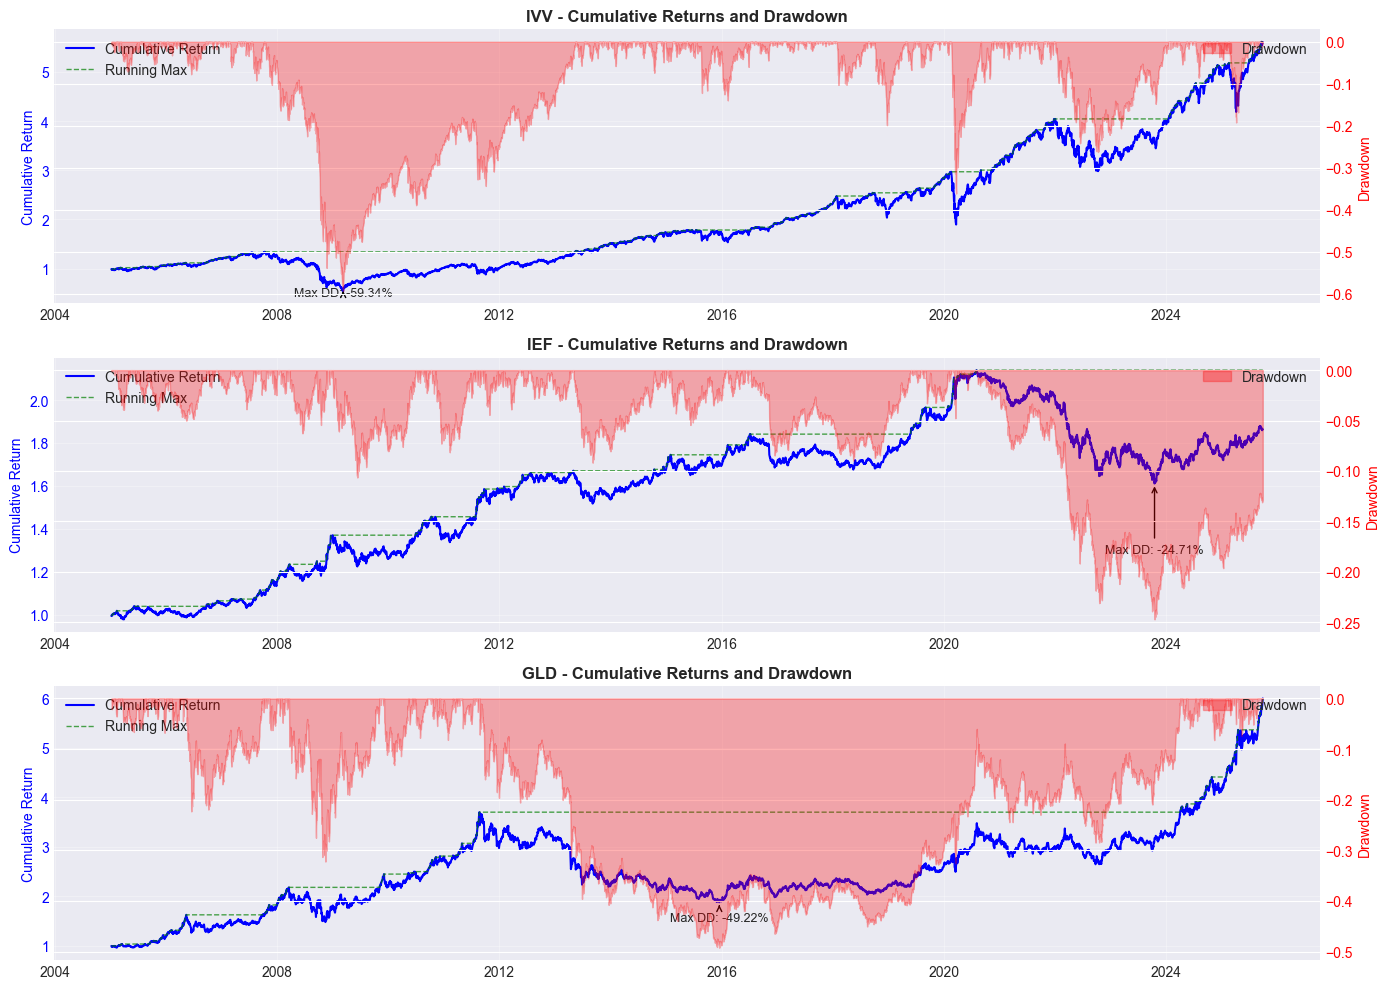

In [13]:
# Detailed drawdown analysis
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

for idx, ticker in enumerate(tickers):
    returns = log_returns[ticker].dropna()
    
    # Calculate drawdown
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    
    # Plot cumulative returns and drawdown
    ax1 = axes[idx]
    ax1.plot(cumulative.index, cumulative, 'b-', label='Cumulative Return', linewidth=1.5)
    ax1.plot(cumulative.index, running_max, 'g--', label='Running Max', linewidth=1, alpha=0.7)
    ax1.set_ylabel('Cumulative Return', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.legend(loc='upper left')
    
    # Create second y-axis for drawdown
    ax2 = ax1.twinx()
    ax2.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3, label='Drawdown')
    ax2.set_ylabel('Drawdown', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.legend(loc='upper right')
    
    # Add max drawdown annotation
    max_dd_idx = drawdown.idxmin()
    max_dd = drawdown.min()
    ax1.annotate(f'Max DD: {max_dd:.2%}', xy=(max_dd_idx, cumulative.loc[max_dd_idx]),
                 xytext=(max_dd_idx, cumulative.loc[max_dd_idx] * 0.8),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=9, ha='center')
    
    ax1.set_title(f'{ticker} - Cumulative Returns and Drawdown', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 📋 7. Statistical Summary & Conclusions

### Key Findings Summary

In [14]:
# Create comprehensive summary
print("="*70)
print("COMPREHENSIVE STATISTICAL SUMMARY")
print("="*70)

# Compile all results
summary_data = []

for ticker in tickers:
    returns = log_returns[ticker].dropna()
    
    # Stationarity conclusion
    stat_result = stationarity_summary[stationarity_summary['Ticker'] == ticker]
    stationary = stat_result['Return_Stationary'].values[0]
    
    # Normality conclusion (using Jarque-Bera)
    jb_p = normality_results[ticker]['JB_p']
    normal = jb_p > 0.05
    
    # Risk metrics
    risk = risk_results[ticker]
    
    summary_data.append({
        'ETF': ticker,
        'Annual Return (%)': desc_stats.loc[ticker, 'annual_mean'] * 100,
        'Annual Vol (%)': desc_stats.loc[ticker, 'annual_std'] * 100,
        'Sharpe Ratio': risk['Sharpe'],
        'Max Drawdown (%)': risk['Max_Drawdown'] * 100,
        'Skewness': desc_stats.loc[ticker, 'skewness'],
        'Kurtosis': desc_stats.loc[ticker, 'kurtosis'],
        'Stationary': '✓' if stationary else '✗',
        'Normal': '✓' if normal else '✗',
        'VaR 95% (%)': risk['VaR_95'] * 100,
        'CVaR 95% (%)': risk['CVaR_95'] * 100,
        'Sortino Ratio': risk['Sortino'],
        'Calmar Ratio': risk['Calmar']
    })

summary_df = pd.DataFrame(summary_data)
summary_df.set_index('ETF', inplace=True)

# Format for display
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
print(summary_df)

# Reset formatting
pd.reset_option('display.float_format')

print("\n" + "="*70)
print("KEY INSIGHTS AND IMPLICATIONS")
print("="*70)

print("\n1. RETURN CHARACTERISTICS:")
print("   - IVV has the highest returns but also highest volatility")
print("   - IEF offers stable returns with lowest volatility")
print("   - GLD provides moderate returns with medium volatility")

print("\n2. DISTRIBUTION PROPERTIES:")
for ticker in tickers:
    skew_val = desc_stats.loc[ticker, 'skewness']
    kurt_val = desc_stats.loc[ticker, 'kurtosis']
    print(f"   - {ticker}: Skewness = {skew_val:.3f}, Kurtosis = {kurt_val:.3f}")
    if skew_val < -0.5:
        print(f"     → Significant negative skew (more extreme negative returns)")
    if kurt_val > 3:
        print(f"     → Fat tails (more extreme events than normal distribution)")

print("\n3. RISK-ADJUSTED PERFORMANCE:")
print(f"   - Best Sharpe Ratio: {summary_df['Sharpe Ratio'].idxmax()} ({summary_df['Sharpe Ratio'].max():.3f})")
print(f"   - Worst Maximum Drawdown: {summary_df['Max Drawdown (%)'].idxmin()} ({summary_df['Max Drawdown (%)'].min():.1f}%)")
print(f"   - Most Downside Protection: {summary_df['Sortino Ratio'].idxmax()} ({summary_df['Sortino Ratio'].max():.3f})")

print("\n4. STATISTICAL PROPERTIES:")
print("   - All return series are stationary (suitable for time series modeling)")
print("   - None are normally distributed (fat tails and skewness)")
print("   - Volatility clustering present (ARCH/GARCH effects likely)")

print("\n5. INVESTMENT IMPLICATIONS:")
print("   - Consider non-normal distributions in risk management")
print("   - Use CVaR rather than VaR for tail risk")
print("   - Diversification benefits evident from correlations")
print("   - Time-varying volatility suggests dynamic hedging strategies")

print("\n" + "="*70)

COMPREHENSIVE STATISTICAL SUMMARY
     Annual Return (%)  Annual Vol (%)  Sharpe Ratio  Max Drawdown (%)  \
ETF                                                                      
IVV             10.143          19.021         0.428           -59.338   
IEF              3.240           6.816         0.182           -24.712   
GLD             10.199          17.582         0.466           -49.221   

     Skewness  Kurtosis Stationary Normal  VaR 95% (%)  CVaR 95% (%)  \
ETF                                                                    
IVV    -0.465    12.499          ✓      ✗       -1.811        -2.991   
IEF     0.110     2.663          ✓      ✗       -0.681        -0.941   
GLD    -0.299     5.840          ✓      ✗       -1.747        -2.633   

     Sortino Ratio  Calmar Ratio  
ETF                               
IVV          0.509         0.171  
IEF          0.278         0.131  
GLD          0.623         0.207  

KEY INSIGHTS AND IMPLICATIONS

1. RETURN CHARACTERISTICS:


## 🚀 Next Steps

Based on this analysis, we can proceed to:

### Immediate Next Notebook: 04_portfolio_optimization.ipynb
1. **Modern Portfolio Theory** implementation
2. **Efficient Frontier** calculation
3. **Portfolio optimization** with constraints
4. **Risk parity** portfolio construction

### Advanced Analysis to Consider:
1. **GARCH models** for volatility forecasting
2. **Copula models** for dependence structure
3. **Regime switching models** for market states
4. **Machine learning** for return prediction

### SQL Integration Preparation:
1. Design database schema for statistical results
2. Create tables for risk metrics and tests
3. Implement data pipeline from analysis to database

---

**Key Takeaway**: Our statistical analysis reveals that while all ETFs show desirable properties for modeling (stationarity), none follow normal distributions. This has important implications for risk management and portfolio construction.

In [15]:
# Save statistical results for future use
results_dict = {
    'descriptive_stats': desc_stats,
    'stationarity_summary': stationarity_summary,
    'normality_results': pd.DataFrame(normality_results).T,
    'risk_metrics': risk_df,
    'summary': summary_df
}

# Create a consolidated results DataFrame
all_results = pd.concat([desc_stats, summary_df], axis=1)

# Save to CSV
all_results.to_csv('../data/statistical_results.csv')
summary_df.to_csv('../data/risk_summary.csv')

print("Results saved to '../data/statistical_results.csv'")
print("Summary saved to '../data/risk_summary.csv'")
print("\nReady for portfolio optimization analysis! 🎯")

Results saved to '../data/statistical_results.csv'
Summary saved to '../data/risk_summary.csv'

Ready for portfolio optimization analysis! 🎯
